### Muli-Objective Linear Programming

From: http://www.supplychaindataanalytics.com/multi-objective-linear-optimization-with-pulp-in-python/

A multi-objective linear optimization problem is a linear optimization problem with more than just one objective function. This area of linear programming is also referred to as multi-objective linear programming or multi-goal linear programming.

Below an examplaric multi-objective linear optimization problem with two objective functions: 

![title](img/multi-objective-linear-problem-PULP.jpg)

Assuming that in above problem statement the two objective functions represent two different goals, such as e.g. service level and profit margin of some product portfolio, I test two alternative approaches for solving this problem.

The first approach will be to solve for one of the objectives, then fix the problem at the optimal outcome of that first problem by adding an additional constraint to a second optimization run where I will then maximize the second objective function (subject to the constraint of keeping the optimal objective value to the first sub-problem).

The second approach will be to add the two objectives together, i.e. to merge them into one objective function by applying weights. By sampling the weights and solving the combined problem for each sampled weight the optimal outcome can be reviewed in dependency of the weights.

### Approach 1: Maximizing for one objective, then adding it as a constraint and solving for the other objective

Using PuLP I maximize the first objective first, then I add that objective function as a constraint to the original problem and maximize the second objective subject to all constraints, including that additional constraint.

In mathematical syntax, the problem we solve first can be stated as follows: 

![title](img/multiobjective-object-1-PULP.jpg)

In [1]:
# first, import PuLP
import pulp

# then, conduct initial declaration of problem
linearProblem = pulp.LpProblem("Maximizing for first objective",pulp.LpMaximize)

# delcare optimization variables, using PuLP
x1 = pulp.LpVariable("x1",lowBound = 0) 
x2 = pulp.LpVariable("x2",lowBound = 0) 

# add (first) objective function to the linear problem statement
linearProblem += 2*x1 + 3*x2 

# add the constraints to the problem
linearProblem += x1 + x2 <= 10
linearProblem += 2*x1 + x2 <= 15

# solve with default solver, maximizing the first objective
solution = linearProblem.solve()

# output information if optimum was found, what the maximal objective value is and what the optimal point is
print(str(pulp.LpStatus[solution])+" ; max value = "+str(pulp.value(linearProblem.objective))+
      " ; x1_opt = "+str(pulp.value(x1))+
      " ; x2_opt = "+str(pulp.value(x2)))


Optimal ; max value = 30.0 ; x1_opt = 0.0 ; x2_opt = 10.0


/home/becode/AI/pulp/pulp/lib/python3.8/site-packages/pulp/pulp.py:1198: UserWarning: Spaces are not permitted in the name. Converted to '_'
  warnings.warn("Spaces are not permitted in the name. Converted to '_'")


Now, I re-state the original problem such that the second objective function is maximized subject to an additional constraint. That additional constraint requests that the first objective must be at least 30. Using mathematical syntax the problem I now solve can be stated as follows: 

![title](img/multiobjective-objective-2-PULP.jpg)

In [2]:
# remodel the problem statement
linearProblem = pulp.LpProblem("Maximize second objective",pulp.LpMaximize)
linearProblem += 4*x1 - 2*x2
linearProblem += x1 + x2 <= 10
linearProblem += 2*x1 + x2 <= 15
linearProblem += 2*x1 + 3*x2 >= 30

# review problem statement after remodelling
linearProblem

Maximize_second_objective:
MAXIMIZE
4*x1 + -2*x2 + 0
SUBJECT TO
_C1: x1 + x2 <= 10

_C2: 2 x1 + x2 <= 15

_C3: 2 x1 + 3 x2 >= 30

VARIABLES
x1 Continuous
x2 Continuous

Now, I solve this problem, using the default solver in PuLP:

In [3]:
# apply default solver
solution = linearProblem.solve()

# output a string summarizing whether optimum was found, and if so what the optimal solution 
print(str(pulp.LpStatus[solution])+" ; max value = "+str(pulp.value(linearProblem.objective))+
      " ; x1_opt = "+str(pulp.value(x1))+
      " ; x2_opt = "+str(pulp.value(x2)))


Optimal ; max value = -19.999999999995993 ; x1_opt = 1.0018653e-12 ; x2_opt = 10.0


This approach suggests that x1 = 0 and x2 = 10 is the the optimal solution. The optimal objective values would be 30 for objective one, and -20 for objective two.

### Approach 2: Combine objectives, using sampled weights and iterations with defined step-size

When applying this approach, we will restate the original problem as follows: 
    
![title](img/multiobjective-combined-objective-PULP.jpg)

The question now is how to choose α.

A typical approach in a situation like this is to identify an efficient frontier. In economics this is e.g. known as “pareto optimality”. To construct such an approach I sample alpha in steps of 0.01. For each value of alpha I restate the problem, using PuLP – and solve it.

I store my results in a list and visualize the outcome using matplotlib.pyplot:

/home/becode/AI/pulp/pulp/lib/python3.8/site-packages/pulp/pulp.py:1198: UserWarning: Spaces are not permitted in the name. Converted to '_'
  warnings.warn("Spaces are not permitted in the name. Converted to '_'")


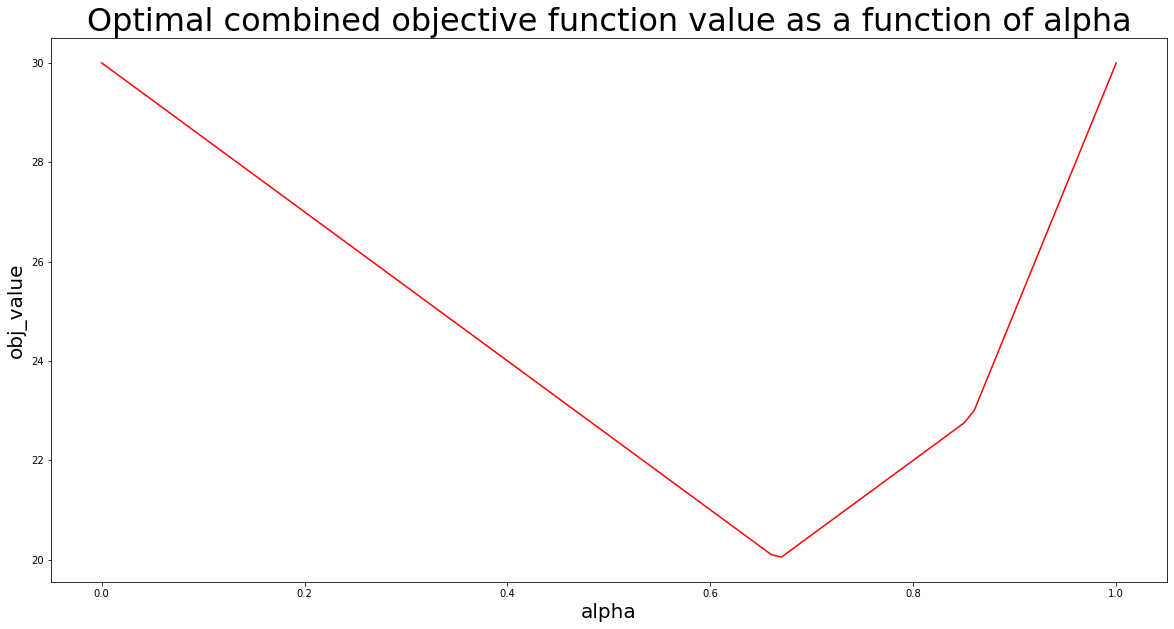

In [4]:
# import matplotlib.pyplot
import matplotlib.pyplot as plt 

# import pandas and numpy for being able to store data in DataFrame format
import numpy as np
import pandas as pd

# define step-size
stepSize = 0.01

# initialize empty DataFrame for storing optimization outcomes
solutionTable = pd.DataFrame(columns=["alpha","x1_opt","x2_opt","obj_value"])

# iterate through alpha values from 0 to 1 with stepSize, and write PuLP solutions into solutionTable
for i in range(0,101,int(stepSize*100)):
        # declare the problem again
        linearProblem = pulp.LpProblem("Multi-objective linear maximization",pulp.LpMaximize)
        # add the objective function at sampled alpha
        linearProblem += (i/100)*(2*x1+3*x2)+(1-i/100)*(4*x1-2*x2)
        # add the constraints
        linearProblem += x1 + x2 <= 10
        linearProblem += 2*x1 + x2 <= 15
        # solve the problem 
        solution = linearProblem.solve()
        # write solutions into DataFrame
        solutionTable.loc[int(i/(stepSize*100))] = [i/100,
                                                     pulp.value(x1),
                                                     pulp.value(x2),
                                                     pulp.value(linearProblem.objective)]

# visualize optimization outcome, using matplotlib.pyplot
# -- set figure size
plt.figure(figsize=(20,10))
# -- create line plot
plt.plot(solutionTable["alpha"],solutionTable["obj_value"],color="red")
# -- add axis labels
plt.xlabel("alpha",size=20)
plt.ylabel("obj_value",size=20)
# -- add plot title
plt.title("Optimal combined objective function value as a function of alpha",size=32)
# -- show plot
plt.show()


In [5]:
solutionTable.head()

,alpha,x1_opt,x2_opt,obj_value
0,0.00,7.5,0.0,30.00
1,0.01,7.5,0.0,29.85
2,0.02,7.5,0.0,29.70
3,0.03,7.5,0.0,29.55
4,0.04,7.5,0.0,29.40
